# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False # was false
            self.adding_lines = False
            self.new_rect()
            self.added_points.append(PointsCollection([])) #mine
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
                self.added_points[-1].add_points([new_point]) #mine
                self.draw(autoscaling = False)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.added_points[-1].add_points([new_point]) #mine
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                    self.added_points[-1].add_points([new_point]) #mine
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

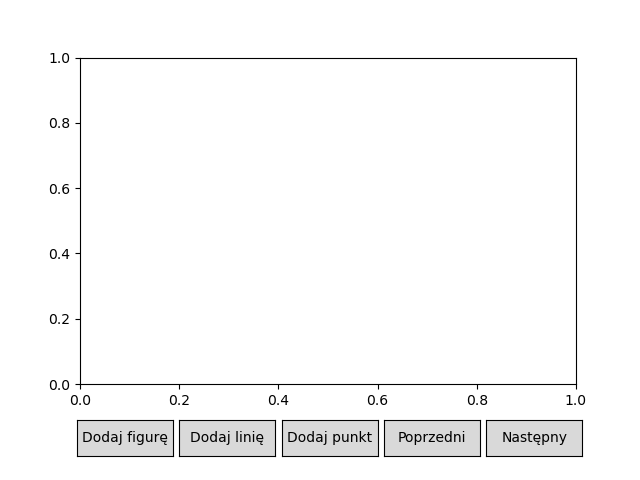

In [20]:
%matplotlib widget

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

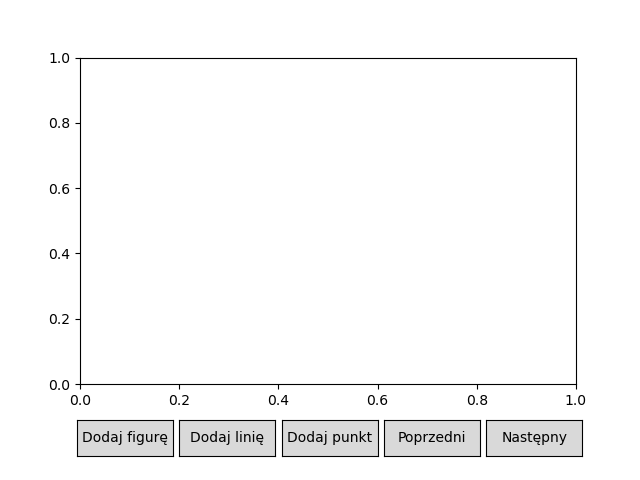

In [5]:
%matplotlib widget

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

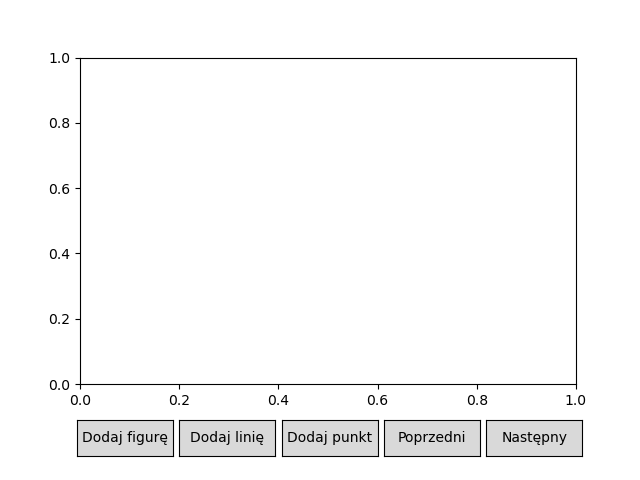

In [6]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

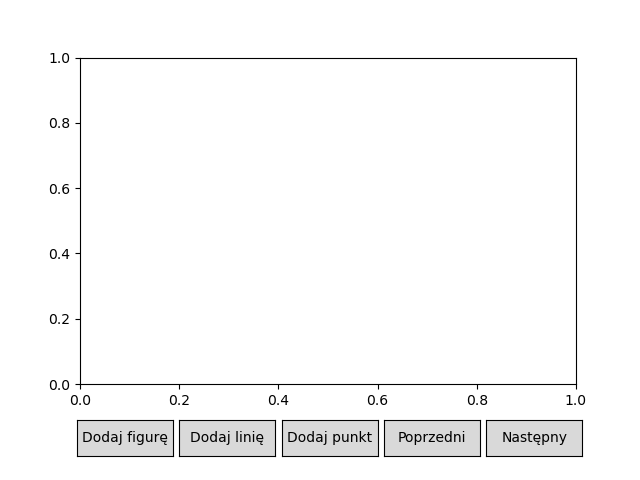

<bound method Plot.get_added_elements of <__main__.Plot object at 0x000001BE20C92820>>


In [33]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

print(plot1.get_added_elements)

[[(1.1661290322580644, 0.2856617647058819), (1.0508064516129032, -0.5636029411764709)], [(1.0508064516129032, -0.5636029411764709), (1.5741935483870968, -0.7152573529411768)], [(1.5741935483870968, -0.7152573529411768), (1.1661290322580644, 0.2856617647058819)]]


### Implementacja funkcji pomocniczych 

In [3]:
eps = 10 ** (-12)

def det(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

In [4]:
from enum import IntEnum

class NodePoint():
    def __init__(self, point, index):
        self.point = point
        self.index = index
        self.next = None
        self.prev = None

class typeOfPoint(IntEnum):
    GREEN = 0,
    BLUE = 1,
    RED = 2,
    NAVY = 3,
    BROWN = 4

def createPolygonRepresentation(polygon_edges):
    head = NodePoint(polygon_edges[0], 0)
    current = head
    prev = head

    ind = 1
    for x in polygon_edges[1:]:
        current = NodePoint(x, ind)
        prev.next = current
        current.prev = prev
        prev = current
        ind += 1

    current.next = head
    head.prev = current

    return head  

### Klasyfikacja punktów dla zadanego wielokąta oraz wizualizacja klasyfikacji sprawdzanie czy wielokąt jest y-monotoniczny

In [5]:
def classifyOneVertex(prev, current, next):
    if current.point[1] > prev.point[1] and current.point[1] > next.point[1]:
        if det(prev.point, current.point, next.point) >= -eps:
            return typeOfPoint.GREEN
        else:
            return typeOfPoint.BLUE
    elif current.point[1] < prev.point[1] and current.point[1] < next.point[1]:
        if det(prev.point, current.point, next.point) >= -eps:
            return typeOfPoint.RED
        else:
            return typeOfPoint.NAVY
    else:
        return typeOfPoint.BROWN

def classifyVertices(head):
    points = [[] for _ in range(5)]
    current = head
    while True:
        type = classifyOneVertex(current.prev, current, current.next)
        points[type.value].append(current.point)
        current = current.next
        if current == head:
            break
    return points

def visualize_points_classification(polygon_vertices, polygon_edges):
    bound_points = PointsCollection([(0, 0), (0, 100), (100, 100), (100, 0)], alpha=0.0)
    #polygon_vertices = plot.get_added_points()[0].points

    head = createPolygonRepresentation(polygon_vertices)
    points = classifyVertices(head)

    colored_points = []
    ind = 0
    for colors in ['green', 'deepskyblue', 'red', 'navy', 'brown']:
        colored_points.append(PointsCollection(points[ind], color = colors))
        ind += 1
    colored_points.append(bound_points)

    plot = Plot(points = colored_points, lines = [LinesCollection(polygon_edges)])
    plot.draw()
    return plot

def is_y_monotone(polygon_vertices):
    head = createPolygonRepresentation(polygon_vertices)
    points = classifyVertices(head)
    return len(points[1]) == 0 and len(points[3]) == 0



### Traiangulacja wielokąta y-monotonicznego oraz wizualizacja kroków algorytmu

In [6]:
%matplotlib widget
#polygon_vertices - vertices of a given polygon in clockwise orientation
#Returns triangulation diagonals as a pair o points
def triangulate_monotone_polygon(polygon_vertices): 
    head = createPolygonRepresentation(polygon_vertices)
    points_with_boundry = createPointsWithBoundry(head)

    stack = []
    stack.append(points_with_boundry[0])
    stack.append(points_with_boundry[1])

    diagonals = []

    for point in points_with_boundry[2:]:
        if point[1] != stack[-1][1]:
            last = stack[-1]
            while stack:
                if not edge_exists(stack[-1][0], point[0]):
                    diagonals.append((stack[-1][0].index,  point[0].index))
                stack.pop()

            stack.append(last)
            stack.append(point)
        else:
            while len(stack) >= 2 and is_triangle_inside(stack[-2], stack[-1], point):
                if not edge_exists(stack[-2][0], point[0]):
                    diagonals.append((stack[-2][0].index, point[0].index))
                stack.pop()
            stack.append(point)
    
    return diagonals

def edge_exists(point_a, point_b):
    return point_a.next == point_b or point_a.prev == point_b


def is_triangle_inside(point_a, point_b, point_c):
    if point_c[1] == 0:
        if det(point_a[0].point, point_b[0].point, point_c[0].point) > eps:
            return True
        else:
            return False
    else:
        if det(point_a[0].point, point_b[0].point, point_c[0].point) > eps:
            return False
        else:
            return True


def createPointsWithBoundry(head):
    points = []
    current = head

    while True:
        points.append(current)
        current = current.next
        if current == head:
            break

    points.sort(key = lambda x : -x.point[1])

    points_with_boundry = []
    current = points[0]
    boundry = 0
    while True:
        points_with_boundry.append((current, boundry))
        current = current.next
        if current == points[-1]:
            boundry = 1
        if current == points[0]:
            break

    points_with_boundry.sort(key = lambda x : -x[0].point[1]) #TODO
    return points_with_boundry

#Wizualizacja powyższego algorytmu
def visualization_of_triangulation(polygon_vertices, polygon_edges):
    scenes = []
    head = createPolygonRepresentation(polygon_vertices)
    points_with_boundry = createPointsWithBoundry(head)

    stack = []
    stack.append(points_with_boundry[0])
    stack.append(points_with_boundry[1])
    diagonals = []
    
    points_on_stack = []
    points_on_stack.append(points_with_boundry[0][0].point)
    points_on_stack.append(points_with_boundry[1][0].point)

    scenes.append(create_scene(polygon_vertices, polygon_edges, [x for x in diagonals]))
    for point in points_with_boundry[2:]:
        if point[1] != stack[-1][1]:
            last = stack[-1]
            while stack:
                if not edge_exists(stack[-1][0], point[0]):
                    diagonals.append([stack[-1][0].point, point[0].point])
                    scenes.append(create_scene(polygon_vertices, polygon_edges, [x for x in diagonals]))
                stack.pop()
                points_on_stack.pop()
                
            stack.append(last)
            stack.append(point)
            points_on_stack.append(last[0].point)
            points_on_stack.append(point[0].point)
        else:
            while len(stack) >= 2 and is_triangle_inside(stack[-2], stack[-1], point):
                if not edge_exists(stack[-2][0], point[0]):
                    diagonals.append([stack[-2][0].point, point[0].point])
                    scenes.append(create_scene(polygon_vertices, polygon_edges, [x for x in diagonals]))
                stack.pop()
                points_on_stack.pop()
            stack.append(point)
            points_on_stack.append(point[0].point)

    return scenes
def create_scene(polygon_vertices, polygon_edges, diagonals):
    bound_points = PointsCollection([(0, 0), (0, 100), (100, 100), (100, 0)], alpha=0.0)
    return Scene(points = [bound_points] + [PointsCollection(polygon_vertices, color = 'orange')], 
                            lines = [LinesCollection(polygon_edges, color = 'black')] + [LinesCollection(diagonals, color = 'black')])




### Zadawanie wielokąta oraz zapisywanie i odczytywanie jego reprezentacji

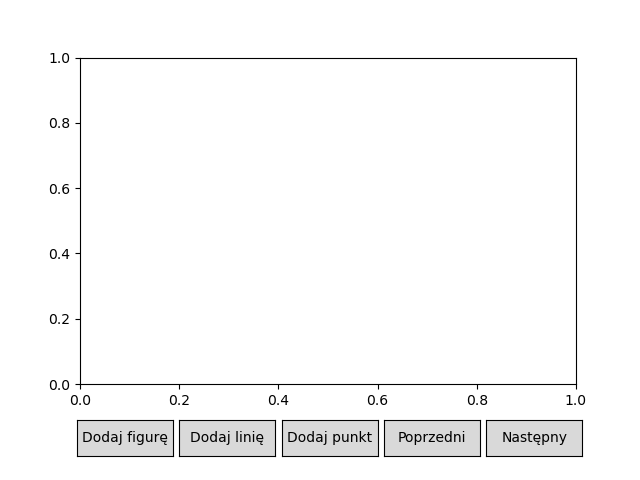

In [7]:
%matplotlib widget
bound_points = PointsCollection([(0, 0), (0, 100), (100, 100), (100, 0)], alpha=0.0)

plot = Plot(points = [bound_points])
plot.draw()


In [11]:
savePolygonToFile(plot, 'lab1')

In [9]:
def savePolygonToFile(plot, path):
    plot = Plot(points = plot.get_added_points(), lines = plot.get_added_figure())

    with open(path + '.json' , 'w') as file:
        file.write(plot.toJson())

In [10]:
def getPolygonFromFile(path):
    with open(path + '.json', 'r') as file:
        json = file.read()
        
    plot = Plot(json=json)

    polygon_vertices = plot.scenes[0].points[0].points
    polygon_edges = plot.scenes[0].lines[0].lines

    return (polygon_vertices, polygon_edges)

### Zastosowanie algorytmów

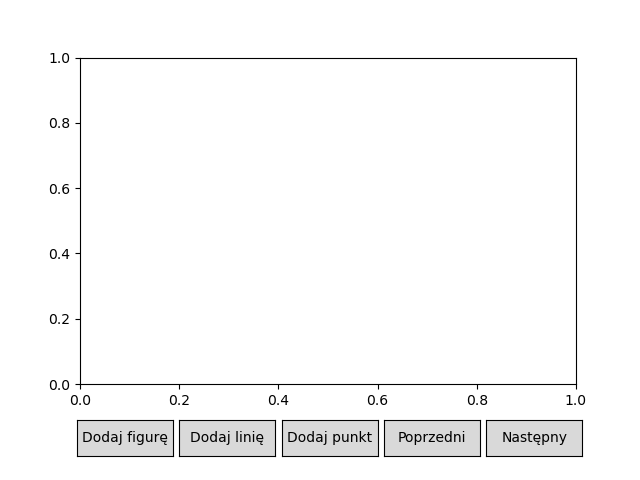

True


In [12]:
%matplotlib widget

polygon_vertices, polygon_edges = getPolygonFromFile('lab1')
plot = visualize_points_classification(polygon_vertices, polygon_edges)

print(is_y_monotone(polygon_vertices))




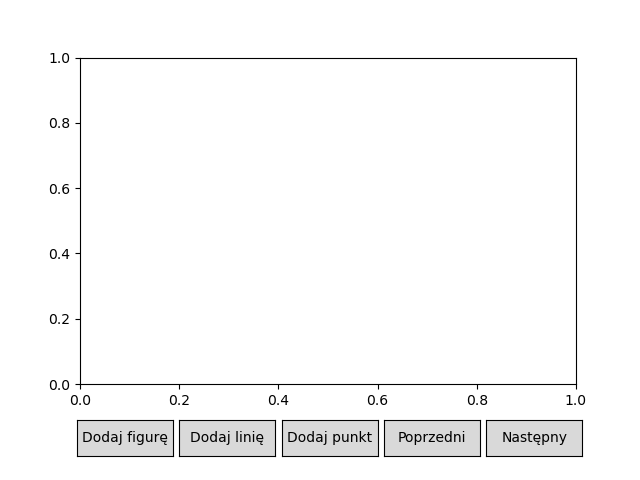

[(7, 5), (7, 4), (7, 3), (7, 2), (2, 0)]


In [13]:
%matplotlib widget
polygon_vertices, polygon_edges = getPolygonFromFile('lab1')

scenes = visualization_of_triangulation(polygon_vertices, polygon_edges)

plot = Plot(scenes = scenes)
plot.draw()

diagonals = triangulate_monotone_polygon(polygon_vertices)
print(diagonals)
